In [1]:
# Import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Load the Excel file into a DataFrame
file_path = 'Antarctic baseline sub-aerial lake data.xlsx'
df = pd.read_excel(file_path)


In [8]:
#DOC model
# Load Excel file into a DataFrame
file_path = 'Antarctic baseline sub-aerial lake data.xlsx'
df = pd.read_excel(file_path)

# Define columns to keep
cols_to_keep = [
    'Conductivity (μS/cm)', 'Temperature (°C)', 'DO (mg/L)', 'pH',
    'Na (mg/L)', 'Cl (mg/L)', 'Mg (mg/L)', 'Si (mg/L)', 'NO2 (mg/L)', 'Ca (mg/L)', 'K (mg/L)',
    'SO4 (mg/L)', 'NO3 (mg/L)', 'PO4 (mg/L)', 'DOC (mg/L)', 'Saline/freshwater'
]

# Keep only the specified columns
df_selected = df[cols_to_keep]

cols_to_impute = [
    'Conductivity (μS/cm)', 'Temperature (°C)', 'DO (mg/L)', 'pH',
    'Na (mg/L)', 'Cl (mg/L)', 'Mg (mg/L)', 'Si (mg/L)', 'NO2 (mg/L)', 'Ca (mg/L)', 'K (mg/L)',
    'SO4 (mg/L)', 'NO3 (mg/L)', 'PO4 (mg/L)', 'DOC (mg/L)'
]

# Replace 'n.a.' with NaN
df_selected.replace('n.a.', np.nan, inplace=True)

# Drop rows where fewer than 9 out of the 15 variables have available data for each sample
cols_to_check = [col for col in cols_to_keep if col not in ['Saline/freshwater']]
df_selected.dropna(subset=cols_to_check, thresh=9, inplace=True)

# Constraints for imputation
min_values = [0 if 'mg/L' in col or col == 'Conductivity (μS/cm)' else
              -50 if col == 'Temperature (°C)' else
              0 if col == 'pH' else
              np.nan for col in cols_to_impute]  # Apply only to cols_to_impute

max_values = [500000 if 'mg/L' in col or col == 'Conductivity (μS/cm)' else
              50 if col == 'Temperature (°C)' else
              14 if col == 'pH' else
              np.nan for col in cols_to_impute]  # Apply only to cols_to_impute

# Initialize the IterativeImputer with min_value and max_value constraints
imputer = IterativeImputer(max_iter=20, random_state=0, min_value=min_values, max_value=max_values)

# Perform imputation
cols_to_impute = [col for col in cols_to_keep if col not in ['Saline/freshwater']]
df_selected.loc[:, cols_to_impute] = imputer.fit_transform(df_selected[cols_to_impute])

# Categorize the samples with missing 'Saline/freshwater' as either Saline or Freshwater based on the imputed Cl or EC
condition_cl = df_selected['Cl (mg/L)'].notna()

df_selected.loc[condition_cl & (df_selected['Cl (mg/L)'] <= 250), 'Saline/freshwater'] = 'Freshwater'

# Define a function to perform robust regression and return the results
def perform_robust_regression(df_subset, water_type):
    # Prepare the independent and dependent variables
    X = df_subset.drop(['DOC (mg/L)', 'Saline/freshwater', 'Conductivity (μS/cm)'], axis=1)
    y = df_subset['DOC (mg/L)']

    # Fit the robust regression model
    X_const = sm.add_constant(X)  # Adding a constant term for the intercept
    model = sm.RLM(y, X_const, M=sm.robust.norms.HuberT())
    results = model.fit()

    # Return the results
    return results.summary(), results.params, results.pvalues, results.nobs

# Separate the data into Saline and Freshwater
df_freshwater = df_selected[df_selected['Saline/freshwater'] == 'Freshwater']
df_saline = df_selected[df_selected['Saline/freshwater'] == 'Saline']

# Perform analysis for Freshwater samples
results_freshwater = perform_robust_regression(df_freshwater, 'Freshwater')

# Perform analysis for Saline samples
results_saline = perform_robust_regression(df_saline, 'Saline')

# Display the results
results_freshwater, results_saline


C:\Users\lizam\AppData\Local\Temp\ipykernel_34808\3591239196.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.replace('n.a.', np.nan, inplace=True)
C:\Users\lizam\AppData\Local\Temp\ipykernel_34808\3591239196.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.dropna(subset=cols_to_check, thresh=9, inplace=True)
C:\Users\lizam\AppData\Local\Temp\ipykernel_34808\3591239196.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

((<class 'statsmodels.iolib.summary.Summary'>
  """
                      Robust linear Model Regression Results                    
  Dep. Variable:             DOC (mg/L)   No. Observations:                  180
  Model:                            RLM   Df Residuals:                      166
  Method:                          IRLS   Df Model:                           13
  Norm:                          HuberT                                         
  Scale Est.:                       mad                                         
  Cov Type:                          H1                                         
  Date:                Thu, 16 Nov 2023                                         
  Time:                        09:32:36                                         
  No. Iterations:                    50                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
  -------------------------------------------------

In [6]:
#K-fold cross validation of DOC model 
from sklearn.model_selection import KFold

# Define the number of folds
n_folds = 5  # You can change this to any number of folds you want to use
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)

# Function to perform k-fold cross-validation on the given dataset
def cross_validate(df, water_type):
    metrics = []  # List to store performance metrics for each fold

    # Split the dataset into folds
    for train_index, test_index in kf.split(df):
        df_train, df_test = df.iloc[train_index], df.iloc[test_index]

        # Perform robust regression on the training set
        X_train = df_train.drop(['DOC (mg/L)', 'Saline/freshwater', 'Conductivity (μS/cm)'], axis=1)
        y_train = df_train['DOC (mg/L)']
        X_train_const = sm.add_constant(X_train)
        model = sm.RLM(y_train, X_train_const, M=sm.robust.norms.HuberT())
        results = model.fit()

        # Evaluate the model on the test set
        X_test = df_test.drop(['DOC (mg/L)', 'Saline/freshwater', 'Conductivity (μS/cm)'], axis=1)
        y_test = df_test['DOC (mg/L)']
        X_test_const = sm.add_constant(X_test)
        predictions = results.predict(X_test_const)

        # Calculate performance metrics (e.g., RMSE)
        metric = np.sqrt(((y_test - predictions) ** 2).mean())  # RMSE
        metrics.append(metric)

    return np.mean(metrics), np.std(metrics)  # Return the mean and standard deviation of the performance metric across folds

# Separate the data into Saline and Freshwater
df_freshwater = df_selected[df_selected['Saline/freshwater'] == 'Freshwater']
df_saline = df_selected[df_selected['Saline/freshwater'] == 'Saline']

# Perform k-fold cross-validation for Freshwater and Saline samples
freshwater_cv_results = cross_validate(df_freshwater, 'Freshwater')
saline_cv_results = cross_validate(df_saline, 'Saline')

# Display the results
print("Freshwater Cross-Validation RMSE: Mean = {:.3f}, Std = {:.3f}".format(*freshwater_cv_results))
print("Saline Cross-Validation RMSE: Mean = {:.3f}, Std = {:.3f}".format(*saline_cv_results))


Freshwater Cross-Validation RMSE: Mean = 1.039, Std = 0.225
Saline Cross-Validation RMSE: Mean = 3.381, Std = 2.054


In [31]:
# Random Forest DOC model
def random_forest_feature_importances_no3(df, features=['Temperature (°C)', 'DO (mg/L)', 'pH',
    'Na (mg/L)', 'Cl (mg/L)', 'Mg (mg/L)', 'Si (mg/L)', 'NO2 (mg/L)', 'Ca (mg/L)', 'K (mg/L)',
    'SO4 (mg/L)', 'NO3 (mg/L)', 'PO4 (mg/L)'], target='DOC (mg/L)'):
    # Split the dataset into features and target
    X = df[features]
    y = df[target]

    # Initialize the RandomForestRegressor
    rf = RandomForestRegressor(n_estimators=100, random_state=0)

    # Fit the Random Forest model
    rf.fit(X, y)

    # Get feature importances
    feature_importances = rf.feature_importances_

    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': feature_importances
    })

    # Sort the DataFrame by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    return feature_importance_df

# Prepare the features (independent variables) excluding 'NO3 (mg/L)' for the NO3 model
features_no3 = df_selected.drop(['DOC (mg/L)', 'Saline/freshwater','Conductivity (μS/cm)'], axis=1).columns

# Perform Random Forest and get feature importances for Freshwater samples for NO3 prediction
freshwater_feature_importances_DOC = random_forest_feature_importances_no3(df_freshwater, features_DOC)

# Perform Random Forest and get feature importances for Saline samples for NO3 prediction
saline_feature_importances_DOC = random_forest_feature_importances_no3(df_saline, features_DOC)

# Display the top 10 feature importances for Freshwater NO3 prediction
print("Freshwater DOC Model Feature Importances:\n", freshwater_feature_importances_no3.head(14))

# Display the top 10 feature importances for Saline NO3 prediction
print("\nSaline DOC Model Feature Importances:\n", saline_feature_importances_no3.head(14))


Freshwater DOC Model Feature Importances:
              Feature  Importance
6          Si (mg/L)    0.957805
8          Ca (mg/L)    0.008099
9           K (mg/L)    0.006896
10        SO4 (mg/L)    0.005418
11        NO3 (mg/L)    0.005055
0   Temperature (°C)    0.003906
1          DO (mg/L)    0.002961
4          Cl (mg/L)    0.002673
5          Mg (mg/L)    0.002543
3          Na (mg/L)    0.002425
12        PO4 (mg/L)    0.001083
2                 pH    0.000649
7         NO2 (mg/L)    0.000486

Saline DOC Model Feature Importances:
              Feature  Importance
6          Si (mg/L)    0.419405
5          Mg (mg/L)    0.222246
8          Ca (mg/L)    0.187899
9           K (mg/L)    0.111960
2                 pH    0.017391
4          Cl (mg/L)    0.012716
1          DO (mg/L)    0.011521
10        SO4 (mg/L)    0.004521
3          Na (mg/L)    0.004425
11        NO3 (mg/L)    0.003725
0   Temperature (°C)    0.003342
12        PO4 (mg/L)    0.000835
7         NO2 (mg/L)    0.

In [9]:
#DOC model
# Load Excel file into a DataFrame
file_path = 'Antarctic baseline sub-aerial lake data.xlsx'
df = pd.read_excel(file_path)

# Define columns to keep
cols_to_keep = [
    'Conductivity (μS/cm)', 'Temperature (°C)', 'DO (mg/L)', 'pH',
    'Na (mg/L)', 'Cl (mg/L)', 'Mg (mg/L)', 'Si (mg/L)', 'NO2 (mg/L)', 'Ca (mg/L)', 'K (mg/L)',
    'SO4 (mg/L)', 'NO3 (mg/L)', 'PO4 (mg/L)', 'DOC (mg/L)', 'Saline/freshwater'
]

# Keep only the specified columns
df_selected = df[cols_to_keep]

cols_to_impute = [
    'Conductivity (μS/cm)', 'Temperature (°C)', 'DO (mg/L)', 'pH',
    'Na (mg/L)', 'Cl (mg/L)', 'Mg (mg/L)', 'Si (mg/L)', 'NO2 (mg/L)', 'Ca (mg/L)', 'K (mg/L)',
    'SO4 (mg/L)', 'NO3 (mg/L)', 'PO4 (mg/L)', 'DOC (mg/L)'
]

# Replace 'n.a.' with NaN
df_selected.replace('n.a.', np.nan, inplace=True)

# Drop rows where fewer than 9 out of the 12 variables have available data
cols_to_check = [col for col in cols_to_keep if col not in ['Saline/freshwater']]
df_selected.dropna(subset=cols_to_check, thresh=9, inplace=True)

# Constraints for imputation
min_values = [0 if 'mg/L' in col or col == 'Conductivity (μS/cm)' else
              -50 if col == 'Temperature (°C)' else
              0 if col == 'pH' else
              np.nan for col in cols_to_impute]  # Apply only to cols_to_impute

max_values = [500000 if 'mg/L' in col or col == 'Conductivity (μS/cm)' else
              50 if col == 'Temperature (°C)' else
              14 if col == 'pH' else
              np.nan for col in cols_to_impute]  # Apply only to cols_to_impute

# Initialize the IterativeImputer with min_value and max_value constraints
imputer = IterativeImputer(max_iter=20, random_state=0, min_value=min_values, max_value=max_values)

# Prepare columns for imputation and perform imputation with constraints
cols_to_impute = [col for col in cols_to_keep if col not in ['Saline/freshwater']]
df_selected.loc[:, cols_to_impute] = imputer.fit_transform(df_selected[cols_to_impute])

# Categorize missing 'Saline/freshwater' based on the imputed Cl concentrations
condition_cl = df_selected['Cl (mg/L)'].notna()

df_selected.loc[condition_cl & (df_selected['Cl (mg/L)'] <= 250), 'Saline/freshwater'] = 'Freshwater'

# Define a function to perform robust regression and return the results
def perform_robust_regression(df_subset, water_type):
    # Prepare the independent and dependent variables
    X = df_subset.drop(['NO3 (mg/L)', 'Saline/freshwater', 'Conductivity (μS/cm)'], axis=1)
    y = df_subset['NO3 (mg/L)']

    # Fit the robust regression model
    X_const = sm.add_constant(X)  # Adding a constant term for the intercept
    model = sm.RLM(y, X_const, M=sm.robust.norms.HuberT())
    results = model.fit()

    # Return the results
    return results.summary(), results.params, results.pvalues, results.nobs

# Separate the data into Saline and Freshwater
df_freshwater = df_selected[df_selected['Saline/freshwater'] == 'Freshwater']
df_saline = df_selected[df_selected['Saline/freshwater'] == 'Saline']

# Perform analysis for Freshwater samples
results_freshwater = perform_robust_regression(df_freshwater, 'Freshwater')

# Perform analysis for Saline samples
results_saline = perform_robust_regression(df_saline, 'Saline')

# Display the results
results_freshwater, results_saline


C:\Users\lizam\AppData\Local\Temp\ipykernel_34808\3625659454.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.replace('n.a.', np.nan, inplace=True)
C:\Users\lizam\AppData\Local\Temp\ipykernel_34808\3625659454.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.dropna(subset=cols_to_check, thresh=9, inplace=True)
C:\Users\lizam\AppData\Local\Temp\ipykernel_34808\3625659454.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

((<class 'statsmodels.iolib.summary.Summary'>
  """
                      Robust linear Model Regression Results                    
  Dep. Variable:             NO3 (mg/L)   No. Observations:                  180
  Model:                            RLM   Df Residuals:                      166
  Method:                          IRLS   Df Model:                           13
  Norm:                          HuberT                                         
  Scale Est.:                       mad                                         
  Cov Type:                          H1                                         
  Date:                Thu, 16 Nov 2023                                         
  Time:                        09:42:53                                         
  No. Iterations:                    50                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
  -------------------------------------------------

In [9]:
#K-fold cross validation of NO3 model 
from sklearn.model_selection import KFold

# Define the number of folds
n_folds = 5  # You can change this to any number of folds you want to use
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)

# Function to perform k-fold cross-validation on the given dataset
def cross_validate(df, water_type):
    metrics = []  # List to store performance metrics for each fold

    # Split the dataset into folds
    for train_index, test_index in kf.split(df):
        df_train, df_test = df.iloc[train_index], df.iloc[test_index]

        # Perform robust regression on the training set
        X_train = df_train.drop(['NO3 (mg/L)', 'Saline/freshwater', 'Conductivity (μS/cm)'], axis=1)
        y_train = df_train['NO3 (mg/L)']
        X_train_const = sm.add_constant(X_train)
        model = sm.RLM(y_train, X_train_const, M=sm.robust.norms.HuberT())
        results = model.fit()

        # Evaluate the model on the test set
        X_test = df_test.drop(['NO3 (mg/L)', 'Saline/freshwater', 'Conductivity (μS/cm)'], axis=1)
        y_test = df_test['NO3 (mg/L)']
        X_test_const = sm.add_constant(X_test)
        predictions = results.predict(X_test_const)

        # Calculate performance metrics (e.g., RMSE)
        metric = np.sqrt(((y_test - predictions) ** 2).mean())  # RMSE
        metrics.append(metric)

    return np.mean(metrics), np.std(metrics)  # Return the mean and standard deviation of the performance metric across folds

# Separate the data into Saline and Freshwater
df_freshwater = df_selected[df_selected['Saline/freshwater'] == 'Freshwater']
df_saline = df_selected[df_selected['Saline/freshwater'] == 'Saline']

# Perform k-fold cross-validation for Freshwater and Saline samples
freshwater_cv_results = cross_validate(df_freshwater, 'Freshwater')
saline_cv_results = cross_validate(df_saline, 'Saline')

# Display the results
print("Freshwater Cross-Validation RMSE: Mean = {:.3f}, Std = {:.3f}".format(*freshwater_cv_results))
print("Saline Cross-Validation RMSE: Mean = {:.3f}, Std = {:.3f}".format(*saline_cv_results))


Freshwater Cross-Validation RMSE: Mean = 12.867, Std = 4.072
Saline Cross-Validation RMSE: Mean = 16.086, Std = 2.703


In [32]:
# Random Forest NO3 model
def random_forest_feature_importances_no3(df, features=['Temperature (°C)', 'DO (mg/L)', 'pH',
    'Na (mg/L)', 'Cl (mg/L)', 'Mg (mg/L)', 'Si (mg/L)', 'NO2 (mg/L)', 'Ca (mg/L)', 'K (mg/L)',
    'SO4 (mg/L)', 'DOC (mg/L)', 'PO4 (mg/L)'], target='NO3 (mg/L)'):
    # Split the dataset into features and target
    X = df[features]
    y = df[target]

    # Initialize the RandomForestRegressor
    rf = RandomForestRegressor(n_estimators=100, random_state=0)

    # Fit the Random Forest model
    rf.fit(X, y)

    # Get feature importances
    feature_importances = rf.feature_importances_

    # Create a DataFrame for feature importances
    feature_importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': feature_importances
    })

    # Sort the DataFrame by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    return feature_importance_df

# Prepare the features (independent variables) excluding 'NO3 (mg/L)' for the NO3 model
features_no3 = df_selected.drop(['NO3 (mg/L)', 'Saline/freshwater','Conductivity (μS/cm)'], axis=1).columns

# Perform Random Forest and get feature importances for Freshwater samples for NO3 prediction
freshwater_feature_importances_no3 = random_forest_feature_importances_no3(df_freshwater, features_no3)

# Perform Random Forest and get feature importances for Saline samples for NO3 prediction
saline_feature_importances_no3 = random_forest_feature_importances_no3(df_saline, features_no3)

# Display the top 10 feature importances for Freshwater NO3 prediction
print("Freshwater NO3 Model Feature Importances:\n", freshwater_feature_importances_no3.head(14))

# Display the top 10 feature importances for Saline NO3 prediction
print("\nSaline NO3 Model Feature Importances:\n", saline_feature_importances_no3.head(14))


Freshwater NO3 Model Feature Importances:
              Feature  Importance
1          DO (mg/L)    0.477972
11        PO4 (mg/L)    0.247219
0   Temperature (°C)    0.203399
4          Cl (mg/L)    0.024673
5          Mg (mg/L)    0.010784
7         NO2 (mg/L)    0.006985
12        DOC (mg/L)    0.005959
6          Si (mg/L)    0.004942
9           K (mg/L)    0.004337
3          Na (mg/L)    0.004127
10        SO4 (mg/L)    0.003954
2                 pH    0.003102
8          Ca (mg/L)    0.002548

Saline NO3 Model Feature Importances:
              Feature  Importance
9           K (mg/L)    0.547602
0   Temperature (°C)    0.289142
6          Si (mg/L)    0.052136
2                 pH    0.037890
12        DOC (mg/L)    0.024965
10        SO4 (mg/L)    0.013665
5          Mg (mg/L)    0.013268
8          Ca (mg/L)    0.006732
11        PO4 (mg/L)    0.004883
3          Na (mg/L)    0.003457
4          Cl (mg/L)    0.003390
1          DO (mg/L)    0.002072
7         NO2 (mg/L)    0.

In [56]:
#K-fold cross validation of NO3 model 

# Define the number of folds
n_folds = 5  # You can change this to any number of folds you want to use
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)

# Function to perform k-fold cross-validation on the given dataset
def cross_validate(df, water_type):
    metrics = []  # List to store performance metrics for each fold

    # Split the dataset into folds
    for train_index, test_index in kf.split(df):
        df_train, df_test = df.iloc[train_index], df.iloc[test_index]

        # Perform robust regression on the training set
        X_train = df_train.drop(['DO (mg/L)', 'Saline/freshwater', 'Conductivity (μS/cm)'], axis=1)
        y_train = df_train['DO (mg/L)']
        X_train_const = sm.add_constant(X_train)
        model = sm.RLM(y_train, X_train_const, M=sm.robust.norms.HuberT())
        results = model.fit()

        # Evaluate the model on the test set
        X_test = df_test.drop(['DO (mg/L)', 'Saline/freshwater', 'Conductivity (μS/cm)'], axis=1)
        y_test = df_test['DO (mg/L)']
        X_test_const = sm.add_constant(X_test)
        predictions = results.predict(X_test_const)

        # Calculate performance metrics (e.g., RMSE)
        metric = np.sqrt(((y_test - predictions) ** 2).mean())  # RMSE
        metrics.append(metric)

    return np.mean(metrics), np.std(metrics)  # Return the mean and standard deviation of the performance metric across folds

# Separate the data into Saline and Freshwater
df_freshwater = df_selected[df_selected['Saline/freshwater'] == 'Freshwater']
df_saline = df_selected[df_selected['Saline/freshwater'] == 'Saline']

# Perform k-fold cross-validation for Freshwater and Saline samples
freshwater_cv_results = cross_validate(df_freshwater, 'Freshwater')
saline_cv_results = cross_validate(df_saline, 'Saline')

# Display the results
print("Freshwater Cross-Validation RMSE: Mean = {:.3f}, Std = {:.3f}".format(*freshwater_cv_results))
print("Saline Cross-Validation RMSE: Mean = {:.3f}, Std = {:.3f}".format(*saline_cv_results))


Freshwater Cross-Validation RMSE: Mean = 0.248, Std = 0.078
Saline Cross-Validation RMSE: Mean = 2.742, Std = 1.180


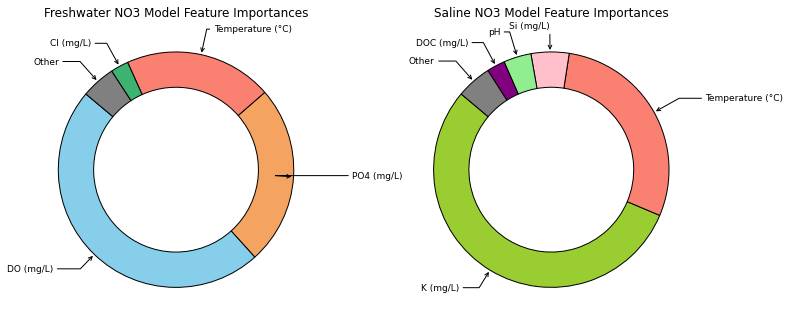

In [21]:
# Define a consistent color mapping for the features across both models
feature_colors = {
    "DO (mg/L)": "skyblue",
    "PO4 (mg/L)": "sandybrown",
    "Temperature (°C)": "salmon",
    "Cl (mg/L)": "mediumseagreen",
    "Mg (mg/L)": "orchid",
    "NO2 (mg/L)": "gold",
    "DOC (mg/L)": "purple",
    "Si (mg/L)": "pink",
    "K (mg/L)": "yellowgreen",
    "Na (mg/L)": "plum",
    "SO4 (mg/L)": "khaki",
    "pH": "lightgreen",
    "Ca (mg/L)": "lightsteelblue",
    "Other": "grey"
}

# Ensure that all possible features are included in the color mapping
all_features = set(freshwater_features_NO3 + saline_features_NO3)
for feature in all_features:
    if feature not in feature_colors:
        feature_colors[feature] = "grey"

# Function to create pie charts with an "Other" category for small values
def make_pie_with_other_category(ax, values, labels, title):
    # Combine smaller values into an "Other" category
    top_values = [value if value >= 0.015 else 0 for value in values]
    top_labels = [label if value >= 0.015 else '' for value, label in zip(values, labels)]
    other_value = sum(value if value < 0.015 else 0 for value in values)
    top_values = [value for value in top_values if value >= 0.015]
    top_labels = [label for label in top_labels if label]

    # If there are any "Other" category values, add them to the list
    if other_value > 0:
        top_values.append(other_value)
        top_labels.append('Other')

    # Get the colors for the top labels
    top_colors = [feature_colors[label] for label in top_labels]

    # Create the pie chart
    wedges, texts = ax.pie(top_values,
                           autopct=None, pctdistance=0.8, colors=top_colors,
                           startangle=140, wedgeprops=dict(width=0.3, edgecolor='black'))

    # Adding leader lines for labels
    for i, wedge in enumerate(wedges):
        if top_labels[i] == 'na':
            continue  # Skip the "Other" category for leader lines
        ang = (wedge.theta2 + wedge.theta1) / 2.
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        ax.annotate(top_labels[i], xy=(x, y), xytext=(1.5*x, 1.2*y),
                    horizontalalignment=horizontalalignment, fontsize=9,
                    arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle))

    # Set the title for the pie chart
    ax.set_title(title)

# Create the figure and the two pie charts
fig, axs = plt.subplots(1, 2, figsize=(11, 5))
make_pie_with_other_category(axs[0], freshwater_values_NO3, freshwater_features_NO3, 'Freshwater NO3 Model Feature Importances')
make_pie_with_other_category(axs[1], saline_values_NO3, saline_features_NO3, 'Saline NO3 Model Feature Importances')

plt.tight_layout()
plt.show()



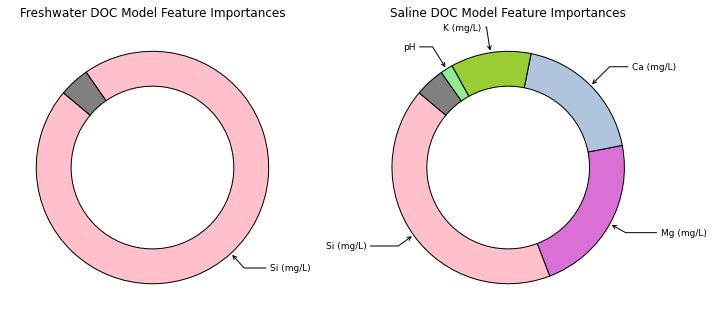

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Define a consistent color mapping for the features across both models
feature_colors = {
    "DO (mg/L)": "skyblue",
    "PO4 (mg/L)": "sandybrown",
    "Temperature (°C)": "salmon",
    "Cl (mg/L)": "mediumseagreen",
    "Mg (mg/L)": "orchid",
    "NO2 (mg/L)": "gold",
    "DOC (mg/L)": "purple",
    "Si (mg/L)": "pink",
    "K (mg/L)": "yellowgreen",
    "Na (mg/L)": "plum",
    "SO4 (mg/L)": "khaki",
    "pH": "lightgreen",
    "Ca (mg/L)": "lightsteelblue",
    "Other": "grey"
}

#DOC model
# Assuming the data for feature importances and names are provided as follows:
freshwater_importances = [0.957805, 0.008099, 0.006896, 0.005418, 0.005055, 0.003906, 0.002961, 0.002673, 0.002543, 0.002425, 0.001083, 0.000649, 0.000486]
freshwater_features = ["Si (mg/L)", "Ca (mg/L)", "K (mg/L)", "SO4 (mg/L)", "NO3 (mg/L)", "Temperature (°C)", "DO (mg/L)", "Cl (mg/L)", "Mg (mg/L)", "Na (mg/L)", "PO4 (mg/L)", "pH", "NO2 (mg/L)"]

saline_importances = [0.419405, 0.222246, 0.187899, 0.111960, 0.017391, 0.012716, 0.011521, 0.004521, 0.004425, 0.003725, 0.003342, 0.000835, 0.000013]
saline_features = ["Si (mg/L)", "Mg (mg/L)", "Ca (mg/L)", "K (mg/L)", "pH", "Cl (mg/L)", "DO (mg/L)", "SO4 (mg/L)", "Na (mg/L)", "NO3 (mg/L)", "Temperature (°C)", "PO4 (mg/L)", "NO2 (mg/L)"]


# Function to create pie charts with an "Other" category for small values
def make_pie_with_other_category(ax, values, labels, title):
    # Combine smaller values into an "Other" category
    top_values = [value if value >= 0.015 else 0 for value in values]
    top_labels = [label if value >= 0.015 else '' for value, label in zip(values, labels)]
    other_value = sum(value if value < 0.015 else 0 for value in values)
    top_values = [value for value in top_values if value >= 0.015]
    top_labels = [label for label in top_labels if label]

    # If there are any "Other" category values, add them to the list
    if other_value > 0:
        top_values.append(other_value)
        top_labels.append('Other')

    # Get the colors for the top labels
    top_colors = [feature_colors[label] for label in top_labels]

    # Create the pie chart
    wedges, texts = ax.pie(top_values,
                           autopct=None, pctdistance=0.8, colors=top_colors,
                           startangle=140, wedgeprops=dict(width=0.3, edgecolor='black'))

    # Adding leader lines for labels
    for i, wedge in enumerate(wedges):
        if top_labels[i] == 'Other':
            continue  # Skip the "Other" category for leader lines
        ang = (wedge.theta2 + wedge.theta1) / 2.
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        ax.annotate(top_labels[i], xy=(x, y), xytext=(1.5*x, 1.2*y),
                    horizontalalignment=horizontalalignment, fontsize=9,
                    arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle))

    # Set the title for the pie chart
    ax.set_title(title)

# Create the figure and the two sets of pie charts
fig, axs = plt.subplots(1, 2, figsize=(10, 7))

# Generate pie charts for both models
make_pie_with_other_category(axs[0], freshwater_importances, freshwater_features, 'Freshwater DOC Model Feature Importances')
make_pie_with_other_category(axs[1], saline_importances, saline_features, 'Saline DOC Model Feature Importances')

# Assuming freshwater_values_DOC and saline_values_DOC are defined similarly
# make_pie_with_other_category(axs[1, 0], freshwater_values_DOC, freshwater_features_DOC, 'Freshwater DOC Model Feature Importances')
# make_pie_with_other_category(axs[1, 1], saline_values_DOC, saline_features_DOC, 'Saline DOC Model Feature Importances')

plt.tight_layout()
plt.show()
